# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [88]:
# Run the comment below only when using Google Colab
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [90]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [91]:
import numpy as np
import datetime
import os, sys

In [92]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [93]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
def get_sample_image(G, n_noise):
    """
        generate an image from a random input
    """
    z = torch.randn(1, n_noise).to(DEVICE)
    print(z)
    y_hat = G(z).view(1, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = [x for x in result[0]]
    return img

In [95]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [96]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [97]:
n_noise = 1

In [98]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [99]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [100]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [101]:
batch_size = 64

In [102]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [103]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [104]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [105]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [106]:
if not os.path.exists('samples_new'):
    os.makedirs('samples_new')

In [107]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples_new/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.38325834274292, G Loss: 0.6940973997116089
tensor([[-1.1423]], device='cuda:0')
Epoch: 0/50, Step: 500, D Loss: 1.3536347150802612, G Loss: 0.6905428171157837
Epoch: 1/50, Step: 1000, D Loss: 1.3080716133117676, G Loss: 0.7578407526016235
tensor([[0.2801]], device='cuda:0')
Epoch: 1/50, Step: 1500, D Loss: 1.299098014831543, G Loss: 0.9045193195343018
Epoch: 2/50, Step: 2000, D Loss: 1.294156551361084, G Loss: 0.9599262475967407
tensor([[0.5308]], device='cuda:0')
Epoch: 2/50, Step: 2500, D Loss: 1.266624093055725, G Loss: 1.4745287895202637
Epoch: 3/50, Step: 3000, D Loss: 1.1962943077087402, G Loss: 1.0235905647277832
tensor([[-1.4165]], device='cuda:0')
Epoch: 3/50, Step: 3500, D Loss: 1.0411065816879272, G Loss: 1.0169897079467773
Epoch: 4/50, Step: 4000, D Loss: 1.3671650886535645, G Loss: 0.8709237575531006
tensor([[0.5211]], device='cuda:0')
Epoch: 4/50, Step: 4500, D Loss: 1.2172660827636719, G Loss: 0.866449236869812
Epoch: 5/50, Step: 5000, D L

## Visualize Sample

tensor([[-1.4666]], device='cuda:0')


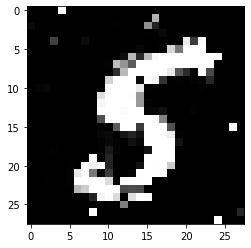

In [126]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [109]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')